<a href="https://colab.research.google.com/github/gitgubbenito/capstone/blob/main/VAERS-v2.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##Capstone Project - Vaccine Adverse Event Reporting System

In [2]:
%reset -f

Data files can be found at the following location:
https://vaers.hhs.gov/data/datasets.html

Datasets were to big to be uploaded to github

I focus on 2021 datasets

In [3]:
#!pip install chardet
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.8 MB/s eta 0:00:00


In [5]:
from datetime import date
import pandas as pd

import random
import statistics
from scipy import stats
from statsmodels.stats import weightstats as stests
from scipy.stats import shapiro
from statsmodels.stats import power
from category_encoders import TargetEncoder, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss, confusion_matrix, classification_report, cohen_kappa_score, accuracy_score, f1_score, roc_curve, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pydotplus

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_score

# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None

# to display the float values upto 6 decimal places
pd.options.display.float_format = '{:.6f}'.format

from sklearn.utils import resample

from wordcloud import WordCloud
from wordcloud import STOPWORDS

import nltk
import re
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from nltk.stem.porter import PorterStemmer

In [ ]:
import chardet
with open('/content/drive/MyDrive/capstone/2021VAERSSYMPTOMS.csv', 'rb') as f:
    data = f.read()
    encoding_result = chardet.detect(data)
    encoding = encoding_result['encoding']
    print("Detected Encoding:", encoding)

Detected Encoding: ascii



#Things to do
- Load all 2021 files - done
- Explore Datasets - done
- Merge Datasets - done
- Data Clean-up - done
- Determine the most common sysmtoms by vaccine manu - Done
- How many people were disable o die due to the vaccine - Done
- Number of VAERS by state - Done
- Plot top 20 symtoms - Done
# Questions to be answer
1.  Do people who experience side effects from the vaccine tend to experience them sooner or later after vaccination?
2.  Can factors like age, gender, vaccine brand, and medical conditions help predict how strongly someone might react to the vaccine?
3.  Is there a noticeable difference in age between those who have no serious side effects and those who do?
4. What are the most common VAERS presented on pacients with COVID-19 vaccine

#ML Model to explore
Clasification models
* K-nearse neibort
* Decision trees
* Logistic regresation
* Support Factor Machine






In [6]:
#Load all 2021 files
df_symptoms_2021 =pd.read_csv('/content/drive/MyDrive/capstone/2021VAERSSYMPTOMS.csv')
df_vaers_data_2021 = pd.read_csv('/content/drive/MyDrive/capstone/2021VAERSDATA.csv',encoding="Windows-1252")
df_vaers_vax_2021 = pd.read_csv('/content/drive/MyDrive/capstone/2021VAERSVAX.csv',encoding="Windows-1252")


In [7]:
print(df_symptoms_2021.head())

   VAERS_ID          SYMPTOM1  SYMPTOMVERSION1              SYMPTOM2  \
0    910642          Dyspnoea        25.000000  Heart rate increased   
1    916600         Dysphagia        23.100000          Epiglottitis   
2    916601           Anxiety        23.100000              Dyspnoea   
3    916602  Chest discomfort        23.100000             Dysphagia   
4    916603         Dizziness        23.100000               Fatigue   

   SYMPTOMVERSION2                  SYMPTOM3  SYMPTOMVERSION3  \
0        25.000000  SARS-CoV-2 test negative        25.000000   
1        23.100000                       NaN              NaN   
2        23.100000                       NaN              NaN   
3        23.100000         Pain in extremity        23.100000   
4        23.100000        Mobility decreased        23.100000   

            SYMPTOM4  SYMPTOMVERSION4 SYMPTOM5  SYMPTOMVERSION5  
0                NaN              NaN      NaN              NaN  
1                NaN              NaN      N

In [8]:
# Concatenate all columns SYMPTOM1, SYMPTOM4, SYMPTOM2,SYMPTOM3, SYMPTOM4, SYMPTOM5

df_symptoms_2021['ALL_SYMPTOMS'] = df_symptoms_2021[['SYMPTOM1', 'SYMPTOM4', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)


In [9]:
# Explore Datasets
print("Shape of df_symptoms_2021:", df_symptoms_2021.shape)
print("Shape of df_vaers_data_2021:", df_vaers_data_2021.shape)
print("Shape of df_vaers_vax_2021:", df_vaers_vax_2021.shape)


Shape of df_symptoms_2021: (1003896, 12)
Shape of df_vaers_data_2021: (753006, 35)
Shape of df_vaers_vax_2021: (797081, 8)


In [10]:
df_symptoms_2021.head(3)

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5,ALL_SYMPTOMS
0,910642,Dyspnoea,25.000000,Heart rate increased,25.000000,SARS-CoV-2 test negative,25.000000,NaN,NaN,NaN,NaN,Dyspnoea Heart rate increased SARS-CoV-2 test ...
1,916600,Dysphagia,23.100000,Epiglottitis,23.100000,NaN,NaN,NaN,NaN,NaN,NaN,Dysphagia Epiglottitis
2,916601,Anxiety,23.100000,Dyspnoea,23.100000,NaN,NaN,NaN,NaN,NaN,NaN,Anxiety Dyspnoea


In [11]:
# prompt: drop FORM_VERS , SYMPTOMVERSION3,SYMPTOMVERSION4,SYMPTOMVERSION1, SYMPTOMVERSION2 , ignore errors

#df_symptoms_2021.drop(columns=['FORM_VERS', 'SYMPTOMVERSION3', 'SYMPTOMVERSION4', 'SYMPTOMVERSION1', 'SYMPTOMVERSION2','SYMPTOMVERSION5' ], errors='ignore', inplace=True)



In [12]:
# prompt: df_symptoms_2021 head

print(df_symptoms_2021.head())


   VAERS_ID          SYMPTOM1              SYMPTOM2                  SYMPTOM3  \
0    910642          Dyspnoea  Heart rate increased  SARS-CoV-2 test negative   
1    916600         Dysphagia          Epiglottitis                       NaN   
2    916601           Anxiety              Dyspnoea                       NaN   
3    916602  Chest discomfort             Dysphagia         Pain in extremity   
4    916603         Dizziness               Fatigue        Mobility decreased   

            SYMPTOM4 SYMPTOM5  \
0                NaN      NaN   
1                NaN      NaN   
2                NaN      NaN   
3  Visual impairment      NaN   
4                NaN      NaN   

                                        ALL_SYMPTOMS  
0  Dyspnoea Heart rate increased SARS-CoV-2 test ...  
1                             Dysphagia Epiglottitis  
2                                   Anxiety Dyspnoea  
3  Chest discomfort Visual impairment Dysphagia P...  
4               Dizziness Fatigue Mobil

In [13]:
# prompt: count unique  SYMPTOMS

num_unique_symptoms = df_symptoms_2021['SYMPTOM1'].nunique()
print(f"Number of unique symptoms: {num_unique_symptoms}")




Number of unique symptoms: 7654


In [14]:
# Explore Datasets
df_symptoms_2021.isnull().sum()

VAERS_ID             0
SYMPTOM1             0
SYMPTOM2        225538
SYMPTOM3        408255
SYMPTOM4        551438
SYMPTOM5        665894
ALL_SYMPTOMS         0
dtype: int64

In [15]:
# prompt: drop VAX_LOT ,  VAX_DOSE_SERIES, VAX_ROUTE , VAX_SITE,

#df_vaers_vax_2021.drop(columns=['VAX_LOT', 'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'SYMPTOMVERSION1', 'SYMPTOMVERSION2', 'SYMPTOMVERSION3', 'SYMPTOMVERSION4', 'SYMPTOMVERSION5', 'RECVDATE', 'RPT_DATE', 'LAB_DATA', 'V_FUNDBY', 'SPLTTYPE', 'FORM_VERS', 'CAGE_MO', 'DATEDIED', 'HOSPDAYS', 'TODAYS_DATE', 'OTHER_MEDS'], errors='ignore',inplace=True)




In [16]:
df_vaers_vax_2021.head()

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_DOSE_SERIES
0,910642,COVID19,PFIZER\BIONTECH,1
1,916600,COVID19,MODERNA,1
2,916601,COVID19,MODERNA,1
3,916602,COVID19,PFIZER\BIONTECH,1
4,916603,COVID19,MODERNA,UNK


In [17]:
# prompt: drop V_FUNDBY, V_ADMINBY, OTHER_MEDS

#df_vaers_data_2021.drop(columns=['V_FUNDBY', 'V_ADMINBY', 'OTHER_MEDS'], inplace=True, errors='ignore')


In [18]:
# prompt: drop PRIOR_VAX, TODAYS_DATE, PRIOR_VAX ,CUR_ILL , LAB_DATA

#df_vaers_data_2021.drop(columns=['PRIOR_VAX', 'TODAYS_DATE', 'PRIOR_VAX' ,'CUR_ILL' , 'LAB_DATA'], inplace=True, errors='ignore')


In [19]:
# Explore Datasets
df_vaers_data_2021.isnull().sum()

VAERS_ID             0
RECVDATE             0
STATE           115887
AGE_YRS          81007
CAGE_YR         148654
CAGE_MO         748705
SEX                  0
RPT_DATE        752078
SYMPTOM_TEXT       577
DIED            742456
DATEDIED        743627
L_THREAT        741891
ER_VISIT        752879
HOSPITAL        705537
HOSPDAYS        721807
X_STAY          752628
DISABLE         741033
RECOVD           73431
VAX_DATE         55745
ONSET_DATE       65815
NUMDAYS          94529
HISTORY         378107
SPLTTYPE        533091
FORM_VERS            0
BIRTH_DEFECT    752547
OFC_VISIT       608478
ER_ED_VISIT     662703
ALLERGIES       454461
dtype: int64

In [20]:
df_vaers_data_2021.head(12)

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,HISTORY,SPLTTYPE,FORM_VERS,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916600,01/01/2021,TX,33.000000,33.000000,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/28/2020,12/30/2020,2.000000,NaN,NaN,2,NaN,Y,NaN,Pcn and bee venom
1,916601,01/01/2021,CA,73.000000,73.000000,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/31/2020,12/31/2020,0.000000,Patient residing at nursing facility. See pati...,NaN,2,NaN,Y,NaN,"""Dairy"""
2,916602,01/01/2021,WA,23.000000,23.000000,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,12/31/2020,12/31/2020,0.000000,NaN,NaN,2,NaN,NaN,Y,Shellfish
3,916603,01/01/2021,WA,58.000000,58.000000,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/23/2020,12/23/2020,0.000000,"diverticulitis, mitral valve prolapse, osteoar...",NaN,2,NaN,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom..."
4,916604,01/01/2021,TX,47.000000,47.000000,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/22/2020,12/29/2020,7.000000,NaN,NaN,2,NaN,NaN,NaN,Na
5,916605,01/01/2021,TX,40.000000,40.000000,NaN,M,NaN,"Adverse Events: Inflammation in the eye, confu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,09/25/2020,09/26/2020,1.000000,NaN,NaN,2,NaN,Y,NaN,NaN
6,916606,01/01/2021,NV,44.000000,44.000000,NaN,F,NaN,patient called back the next day and stated he...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/29/2020,12/29/2020,0.000000,NaN,NaN,2,NaN,NaN,NaN,iodine (shellfish) has epipen
7,916607,01/01/2021,KS,50.000000,50.000000,NaN,M,NaN,SEVERE chills approximately 13-14 hours after ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/28/2020,12/29/2020,1.000000,"High blood pressure, high cholesterol, sleep a...",NaN,2,NaN,NaN,NaN,Penicillin
8,916608,01/01/2021,OH,33.000000,33.000000,NaN,M,NaN,Nasal congestion and diarrhea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12/29/2020,12/31/2020,2.000000,NaN,NaN,2,NaN,NaN,NaN,NaN
9,916609,01/01/2021,TN,71.000000,71.000000,NaN,F,NaN,On day 9 following the vaccination I noticed a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/23/2020,12/31/2020,8.000000,"Hashimoto's thyroiditis, Hypertension, depression",NaN,2,NaN,NaN,NaN,"Sulfa antibiotics, azithromycin, adhesive in ..."


In [8]:
# prompt: set all DIED rows that are not equal to Y to N

df_vaers_data_2021['DIED'] = df_vaers_data_2021['DIED'].apply(lambda x: 'N' if x != 'Y' else x)


In [9]:
# prompt:  DIED column count

died_count = df_vaers_data_2021['DIED'].value_counts()
print(died_count)




DIED
N    742456
Y     10550
Name: count, dtype: int64


In [10]:
# Explore Datasets
df_symptoms_2021.isnull().sum()

VAERS_ID                0
SYMPTOM1                0
SYMPTOMVERSION1         0
SYMPTOM2           225538
SYMPTOMVERSION2    225538
SYMPTOM3           408255
SYMPTOMVERSION3    408255
SYMPTOM4           551438
SYMPTOMVERSION4    551438
SYMPTOM5           665894
SYMPTOMVERSION5    665894
dtype: int64

In [11]:
df_vaers_data_2021.isnull().sum()/len(df_vaers_data_2021) * 100

VAERS_ID        0.000000
RECVDATE        0.000000
STATE          15.389917
AGE_YRS        10.757816
CAGE_YR        19.741410
CAGE_MO        99.428823
SEX             0.000000
RPT_DATE       99.876761
SYMPTOM_TEXT    0.076626
DIED            0.000000
DATEDIED       98.754459
L_THREAT       98.523916
ER_VISIT       99.983134
HOSPITAL       93.696066
HOSPDAYS       95.856740
X_STAY         99.949801
DISABLE        98.409973
RECOVD          9.751715
VAX_DATE        7.402995
ONSET_DATE      8.740302
NUMDAYS        12.553552
LAB_DATA       69.560800
V_ADMINBY       0.000000
V_FUNDBY       99.867597
OTHER_MEDS     50.582598
CUR_ILL        72.307126
HISTORY        50.213013
PRIOR_VAX      95.158870
SPLTTYPE       70.795053
FORM_VERS       0.000000
TODAYS_DATE     0.738374
BIRTH_DEFECT   99.939044
OFC_VISIT      80.806527
ER_ED_VISIT    88.007665
ALLERGIES      60.352906
dtype: float64

In [12]:
df_vaers_data_2021.head(5)

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916600,01/01/2021,TX,33.000000,33.000000,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/28/2020,12/30/2020,2.000000,NaN,PVT,NaN,NaN,NaN,NaN,NaN,NaN,2,01/01/2021,NaN,Y,NaN,Pcn and bee venom
1,916601,01/01/2021,CA,73.000000,73.000000,NaN,F,NaN,Approximately 30 min post vaccination administ...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/31/2020,12/31/2020,0.000000,NaN,SEN,NaN,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,NaN,NaN,2,01/01/2021,NaN,Y,NaN,"""Dairy"""
2,916602,01/01/2021,WA,23.000000,23.000000,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,12/31/2020,12/31/2020,0.000000,NaN,SEN,NaN,NaN,NaN,NaN,NaN,NaN,2,01/01/2021,NaN,NaN,Y,Shellfish
3,916603,01/01/2021,WA,58.000000,58.000000,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/23/2020,12/23/2020,0.000000,none,WRK,NaN,none,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","got measles from measel shot, mums from mumps ...",NaN,2,01/01/2021,NaN,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom..."
4,916604,01/01/2021,TX,47.000000,47.000000,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/22/2020,12/29/2020,7.000000,NaN,PUB,NaN,Na,Na,NaN,NaN,NaN,2,01/01/2021,NaN,NaN,NaN,Na


In [27]:
# Drop  Columns
#df_vaers_data_2021 = df_vaers_data_2021.drop(columns =['DISABLE','HOSPITAL','ER_VISIT','L_THREAT','X_STAY','CAGE_YR', 'CAGE_MO', 'RPT_DATE', 'ONSET_DATE','NUMDAYS', 'LAB_DATA', 'SYMPTOM_TEXT','V_ADMINBY', 'DATEDIED', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL', 'PRIOR_VAX','VAX_DATE','SPLTTYPE', 'FORM_VERS', 'TODAYS_DATE', 'OFC_VISIT', 'HISTORY', 'ER_ED_VISIT', 'ALLERGIES','RECVDATE','STATE','HOSPDAYS','X_STAY','RECOVD','BIRTH_DEFECT'],errors='ignore')






In [13]:
df_vaers_data_2021.columns

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES'],
      dtype='object')

**Note:** I will focus in column: SYMPTOM1

In [14]:
df_vaers_data_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753006 entries, 0 to 753005
Data columns (total 35 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   VAERS_ID      753006 non-null  int64  
 1   RECVDATE      753006 non-null  object 
 2   STATE         637119 non-null  object 
 3   AGE_YRS       671999 non-null  float64
 4   CAGE_YR       604352 non-null  float64
 5   CAGE_MO       4301 non-null    float64
 6   SEX           753006 non-null  object 
 7   RPT_DATE      928 non-null     object 
 8   SYMPTOM_TEXT  752429 non-null  object 
 9   DIED          753006 non-null  object 
 10  DATEDIED      9379 non-null    object 
 11  L_THREAT      11115 non-null   object 
 12  ER_VISIT      127 non-null     object 
 13  HOSPITAL      47469 non-null   object 
 14  HOSPDAYS      31199 non-null   float64
 15  X_STAY        378 non-null     object 
 16  DISABLE       11973 non-null   object 
 17  RECOVD        679575 non-null  object 
 18  VAX_

In [15]:
df_symptoms_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003896 entries, 0 to 1003895
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   VAERS_ID         1003896 non-null  int64  
 1   SYMPTOM1         1003896 non-null  object 
 2   SYMPTOMVERSION1  1003896 non-null  float64
 3   SYMPTOM2         778358 non-null   object 
 4   SYMPTOMVERSION2  778358 non-null   float64
 5   SYMPTOM3         595641 non-null   object 
 6   SYMPTOMVERSION3  595641 non-null   float64
 7   SYMPTOM4         452458 non-null   object 
 8   SYMPTOMVERSION4  452458 non-null   float64
 9   SYMPTOM5         338002 non-null   object 
 10  SYMPTOMVERSION5  338002 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 84.3+ MB


In [32]:
# prompt: drop SYMPTOMVERSION1. SYMPTOMVERSION2 , SYMPTOMVERSION3, SYMPTOMVERSION4, SYMPTOMVERSION5

#df_symptoms_2021.drop(['SYMPTOMVERSION1', 'SYMPTOMVERSION2', 'SYMPTOMVERSION3', 'SYMPTOMVERSION4', 'SYMPTOMVERSION5'], axis=1, inplace=True,errors='ignore')


In [16]:
# prompt: how many vaers are by vacine manu

#df_vaers_vax_2021['VAX_MANU'].value_counts()
df_vaers_vax_2021['VAX_TYPE'].value_counts(normalize= True) * 100


VAX_TYPE
COVID19      93.103587
VARZOS        1.800193
UNK           1.187960
FLU4          0.681361
HPV9          0.228835
VARCEL        0.219551
TDAP          0.209264
PPV           0.206378
FLUX          0.178275
HEPA          0.177648
MMR           0.177397
MNQ           0.175139
HEP           0.173383
MMRV          0.155442
PNC13         0.137627
HIBV          0.116676
DTAP          0.097606
MENB          0.095599
DTAPIPV       0.095348
RV5           0.091710
FLUA4         0.087946
FLUC4         0.086942
DTAPIPVHIB    0.073644
FLUR4         0.066869
DTAPHEPBIP    0.055076
IPV           0.051814
HEPAB         0.024464
TYP           0.024339
RAB           0.023837
RV1           0.023335
FLU3          0.021579
TD            0.021328
HPV4          0.017815
ANTH          0.014804
FLUA3         0.013048
YF            0.012169
FLUC3         0.008029
FLUN4         0.007778
MEN           0.006524
ADEN_4_7      0.005395
EBZR          0.004893
TTOX          0.004391
DF            0.003764
SM

In [17]:
# prompt: merge all 3 data frame

df_combine_2021 = pd.merge(df_vaers_data_2021, df_vaers_vax_2021, on='VAERS_ID', how='inner')
df_combine_2021 = pd.merge(df_combine_2021, df_symptoms_2021, on='VAERS_ID', how='inner')


In [18]:
len(df_combine_2021[df_combine_2021.duplicated(subset= ['VAERS_ID'])== True])
df_combine_2021 = df_combine_2021.drop_duplicates(subset= ['VAERS_ID'], keep= 'first')
# Checking dimension of data after dropping duplicates:
df_combine_2021.shape

(753003, 52)

In [21]:
cat = []
num = []

for i in df_combine_2021.columns:
    if df_combine_2021[i].dtype==object:
        cat.append(i)
    else:
        num.append(i)

print("The number of numerical features are:",len(num))
print()
print("The numerical features are:\n\n",num)
print("\n\n")
print("The number of categorical features are:", len(cat))
print()
print("The categorical features are:\n\n",cat)

The number of numerical features are: 12

The numerical features are:

 ['VAERS_ID', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'HOSPDAYS', 'NUMDAYS', 'FORM_VERS', 'SYMPTOMVERSION1', 'SYMPTOMVERSION2', 'SYMPTOMVERSION3', 'SYMPTOMVERSION4', 'SYMPTOMVERSION5']



The number of categorical features are: 40

The categorical features are:

 ['RECVDATE', 'STATE', 'SEX', 'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE', 'ONSET_DATE', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES', 'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']


In [22]:
df_combine_2021.info()
df_combine_2021.set_index('VAERS_ID', inplace= True)
df_combine_2021.head()

<class 'pandas.core.frame.DataFrame'>
Index: 753003 entries, 0 to 1070233
Data columns (total 52 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         753003 non-null  int64  
 1   RECVDATE         753003 non-null  object 
 2   STATE            637116 non-null  object 
 3   AGE_YRS          671996 non-null  float64
 4   CAGE_YR          604350 non-null  float64
 5   CAGE_MO          4301 non-null    float64
 6   SEX              753003 non-null  object 
 7   RPT_DATE         928 non-null     object 
 8   SYMPTOM_TEXT     752426 non-null  object 
 9   DIED             753003 non-null  object 
 10  DATEDIED         9379 non-null    object 
 11  L_THREAT         11113 non-null   object 
 12  ER_VISIT         127 non-null     object 
 13  HOSPITAL         47468 non-null   object 
 14  HOSPDAYS         31198 non-null   float64
 15  X_STAY           378 non-null     object 
 16  DISABLE          11973 non-null   object 


,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
VAERS_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
916600,01/01/2021,TX,33.000000,33.000000,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/28/2020,12/30/2020,2.000000,NaN,PVT,NaN,NaN,NaN,NaN,NaN,NaN,2,01/01/2021,NaN,Y,NaN,Pcn and bee venom,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA)),Dysphagia,23.100000,Epiglottitis,23.100000,NaN,NaN,NaN,NaN,NaN,NaN
916601,01/01/2021,CA,73.000000,73.000000,NaN,F,NaN,Approximately 30 min post vaccination administ...,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/31/2020,12/31/2020,0.000000,NaN,SEN,NaN,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,NaN,NaN,2,01/01/2021,NaN,Y,NaN,"""Dairy""",COVID19,MODERNA,025L20A,1,IM,RA,COVID19 (COVID19 (MODERNA)),Anxiety,23.100000,Dyspnoea,23.100000,NaN,NaN,NaN,NaN,NaN,NaN
916602,01/01/2021,WA,23.000000,23.000000,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,12/31/2020,12/31/2020,0.000000,NaN,SEN,NaN,NaN,NaN,NaN,NaN,NaN,2,01/01/2021,NaN,NaN,Y,Shellfish,COVID19,PFIZER\BIONTECH,EL1284,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),Chest discomfort,23.100000,Dysphagia,23.100000,Pain in extremity,23.100000,Visual impairment,23.100000,NaN,NaN
916603,01/01/2021,WA,58.000000,58.000000,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/23/2020,12/23/2020,0.000000,none,WRK,NaN,none,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","got measles from measel shot, mums from mumps ...",NaN,2,01/01/2021,NaN,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom...",COVID19,MODERNA,unknown,UNK,NaN,NaN,COVID19 (COVID19 (MODERNA)),Dizziness,23.100000,Fatigue,23.100000,Mobility decreased,23.100000,NaN,NaN,NaN,NaN
916604,01/01/2021,TX,47.000000,47.000000,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/22/2020,12/29/2020,7.000000,NaN,PUB,NaN,Na,Na,NaN,NaN,NaN,2,01/01/2021,NaN,NaN,NaN,Na,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA)),Injection site erythema,23.100000,Injection site pruritus,23.100000,Injection site swelling,23.100000,Injection site warmth,23.100000,NaN,NaN


In [24]:
df_combine_2021.columns

Index(['RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX', 'RPT_DATE',
       'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL',
       'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE', 'ONSET_DATE',
       'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL',
       'HISTORY', 'PRIOR_VAX', 'SPLTTYPE', 'FORM_VERS', 'TODAYS_DATE',
       'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES', 'VAX_TYPE',
       'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES', 'VAX_ROUTE', 'VAX_SITE',
       'VAX_NAME', 'SYMPTOM1', 'SYMPTOMVERSION1', 'SYMPTOM2',
       'SYMPTOMVERSION2', 'SYMPTOM3', 'SYMPTOMVERSION3', 'SYMPTOM4',
       'SYMPTOMVERSION4', 'SYMPTOM5', 'SYMPTOMVERSION5'],
      dtype='object')

In [25]:
# Reset the index to bring 'VAERS_ID' back as a column
df_combine_2021 = df_combine_2021.reset_index()

len(df_combine_2021[df_combine_2021.duplicated(subset=['VAERS_ID']) == True])
# Dropping duplicate records keeping the first record:

print(df_combine_2021.shape)
df_combine_2021 = df_combine_2021.drop_duplicates(subset=['VAERS_ID'], keep='first')

# Checking dimension of data after dropping duplicates:
print(df_combine_2021.shape)

(753003, 52)
(753003, 52)


In [42]:
print(df_combine_2021.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753003 entries, 0 to 753002
Data columns (total 52 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         753003 non-null  int64  
 1   RECVDATE         753003 non-null  object 
 2   STATE            637116 non-null  object 
 3   AGE_YRS          671996 non-null  float64
 4   CAGE_YR          604350 non-null  float64
 5   CAGE_MO          4301 non-null    float64
 6   SEX              753003 non-null  object 
 7   RPT_DATE         928 non-null     object 
 8   SYMPTOM_TEXT     752426 non-null  object 
 9   DIED             10550 non-null   object 
 10  DATEDIED         9379 non-null    object 
 11  L_THREAT         11113 non-null   object 
 12  ER_VISIT         127 non-null     object 
 13  HOSPITAL         47468 non-null   object 
 14  HOSPDAYS         31198 non-null   float64
 15  X_STAY           378 non-null     object 
 16  DISABLE          11973 non-null   obje

In [43]:
# prompt: how many people died by sex

died_by_sex = df_combine_2021.groupby('SEX')['DIED'].value_counts()

print(died_by_sex)


SEX  DIED
F    Y       4110
M    Y       5993
U    Y        447
Name: count, dtype: int64


In [44]:
#df_v1 = df_combine_2021.drop(columns=['VAX_LOT', 'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'SYMPTOMVERSION1', 'SYMPTOMVERSION2', 'SYMPTOMVERSION3', 'SYMPTOMVERSION4', 'SYMPTOMVERSION5', 'RECVDATE', 'RPT_DATE', 'LAB_DATA', 'V_FUNDBY', 'SPLTTYPE', 'FORM_VERS', 'CAGE_MO', 'DATEDIED', 'HOSPDAYS', 'TODAYS_DATE', 'OTHER_MEDS'])


In [45]:
df_combine_2021.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,916600,01/01/2021,TX,33.000000,33.000000,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/28/2020,12/30/2020,2.000000,NaN,PVT,NaN,NaN,NaN,NaN,NaN,NaN,2,01/01/2021,NaN,Y,NaN,Pcn and bee venom,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA)),Dysphagia,23.100000,Epiglottitis,23.100000,NaN,NaN,NaN,NaN,NaN,NaN
1,916601,01/01/2021,CA,73.000000,73.000000,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/31/2020,12/31/2020,0.000000,NaN,SEN,NaN,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,NaN,NaN,2,01/01/2021,NaN,Y,NaN,"""Dairy""",COVID19,MODERNA,025L20A,1,IM,RA,COVID19 (COVID19 (MODERNA)),Anxiety,23.100000,Dyspnoea,23.100000,NaN,NaN,NaN,NaN,NaN,NaN
2,916602,01/01/2021,WA,23.000000,23.000000,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,12/31/2020,12/31/2020,0.000000,NaN,SEN,NaN,NaN,NaN,NaN,NaN,NaN,2,01/01/2021,NaN,NaN,Y,Shellfish,COVID19,PFIZER\BIONTECH,EL1284,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),Chest discomfort,23.100000,Dysphagia,23.100000,Pain in extremity,23.100000,Visual impairment,23.100000,NaN,NaN
3,916603,01/01/2021,WA,58.000000,58.000000,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,12/23/2020,12/23/2020,0.000000,none,WRK,NaN,none,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","got measles from measel shot, mums from mumps ...",NaN,2,01/01/2021,NaN,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom...",COVID19,MODERNA,unknown,UNK,NaN,NaN,COVID19 (COVID19 (MODERNA)),Dizziness,23.100000,Fatigue,23.100000,Mobility decreased,23.100000,NaN,NaN,NaN,NaN
4,916604,01/01/2021,TX,47.000000,47.000000,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,12/22/2020,12/29/2020,7.000000,NaN,PUB,NaN,Na,Na,NaN,NaN,NaN,2,01/01/2021,NaN,NaN,NaN,Na,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA)),Injection site erythema,23.100000,Injection site pruritus,23.100000,Injection site swelling,23.100000,Injection site warmth,23.100000,NaN,NaN


In [26]:
# prompt: how many rows and columns are there for each df

print("df_symptoms_2021 has", df_symptoms_2021.shape[0], "rows and", df_symptoms_2021.shape[1], "columns")
print("df_vaers_data_2021 has", df_vaers_data_2021.shape[0], "rows and", df_vaers_data_2021.shape[1], "columns")
print("df_vaers_vax_2021 has", df_vaers_vax_2021.shape[0], "rows and", df_vaers_vax_2021.shape[1], "columns")
print("df_combine_2021 has", df_combine_2021.shape[0], "rows and", df_combine_2021.shape[1], "columns")


df_symptoms_2021 has 1003896 rows and 11 columns
df_vaers_data_2021 has 753006 rows and 35 columns
df_vaers_vax_2021 has 797081 rows and 8 columns
df_combine_2021 has 753003 rows and 52 columns


In [27]:
# prompt: Determine the top 12 most common sysmtoms by vaccine manu

top_12_symptoms = df_combine_2021.groupby('VAX_MANU')['SYMPTOM1'].value_counts().sort_values(ascending=False).head(12)
print(top_12_symptoms)


VAX_MANU         SYMPTOM1               
MODERNA          Chills                     27873
                 Arthralgia                 19522
PFIZER\BIONTECH  Chills                     18298
                 Arthralgia                 16877
                 Dizziness                  15245
MODERNA          Injection site erythema    14281
PFIZER\BIONTECH  COVID-19                   13841
MODERNA          Fatigue                    11811
                 Dizziness                  11130
                 Asthenia                    9787
PFIZER\BIONTECH  Fatigue                     9495
MODERNA          Erythema                    9357
Name: count, dtype: int64


In [47]:
# prompt: systoms for people who die value counts

df_combine_2021.groupby('DIED')['SYMPTOM1'].value_counts()


DIED  SYMPTOM1                                                                       
N     Chills                                                                             54649
      Arthralgia                                                                         41162
      Dizziness                                                                          30579
      Fatigue                                                                            24258
      COVID-19                                                                           22445
      Asthenia                                                                           20925
      Headache                                                                           19641
      Injection site erythema                                                            17188
      Expired product administered                                                       14671
      Erythema                                             

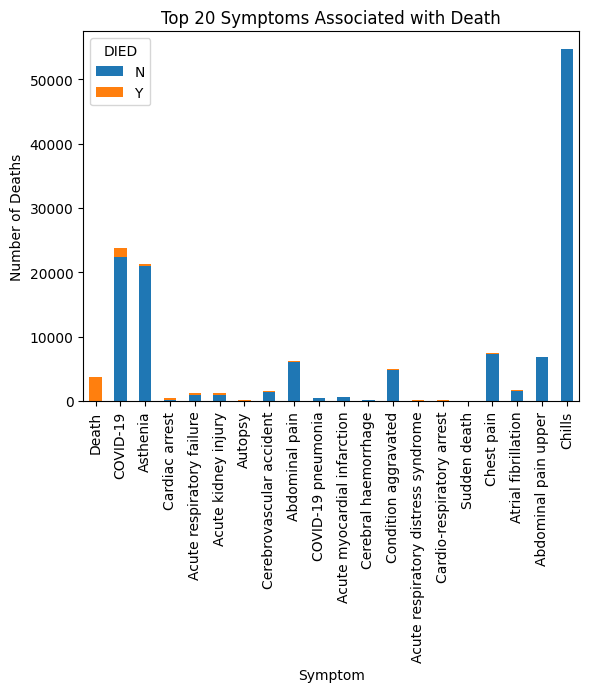

In [48]:
# prompt: plot the most common systom1 who DIED top 20

import matplotlib.pyplot as plt

# Group the data by SYMPTOM1 and DIED
grouped_data = df_combine_2021.groupby(['SYMPTOM1', 'DIED'])['VAERS_ID'].count().unstack()

# Sort the data by the number of deaths
grouped_data = grouped_data.sort_values(by='Y', ascending=False)

# Select the top 20 symptoms
top_20_symptoms = grouped_data.head(20)

# Plot the data as a bar chart
top_20_symptoms.plot(kind='bar', stacked=True)
plt.xlabel('Symptom')
plt.ylabel('Number of Deaths')
plt.title('Top 20 Symptoms Associated with Death')
plt.show()


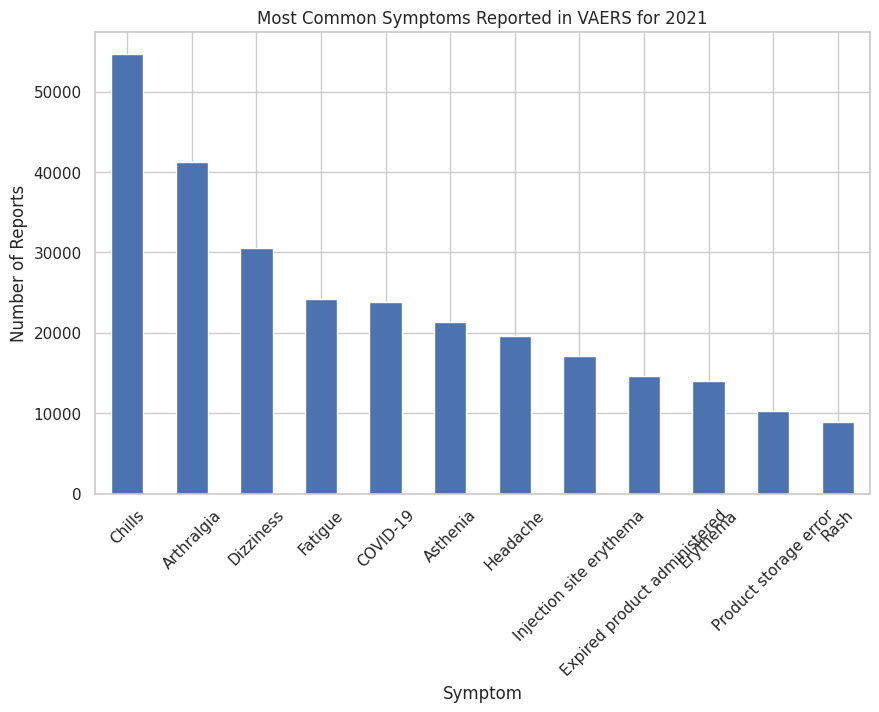

In [48]:
# prompt: plot the most common systom1 and plot it

import matplotlib.pyplot as plt

# Get the top 12 symptoms
top_12_symptoms = df_combine_2021.groupby('SYMPTOM1')['VAERS_ID'].count().sort_values(ascending=False).head(12)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_12_symptoms.plot(kind='bar')

# Add title and labels
plt.title('Most Common Symptoms Reported in VAERS for 2021')
plt.xlabel('Symptom')
plt.ylabel('Number of Reports')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [49]:
# prompt: how many people die by vacine manu

#df_combine_2021.groupby('VAX_MANU')['DIED'].sum()
df_combine_2021.groupby('VAX_MANU')['DIED'].value_counts()


VAX_MANU                           DIED
BERNA BIOTECH, LTD.                N           96
CSL LIMITED                        N            8
DYNAVAX TECHNOLOGIES CORPORATION   N          237
                                   Y            1
EMERGENT BIOSOLUTIONS              N          127
GLAXOSMITHKLINE BIOLOGICALS        N        13843
                                   Y           34
INTERCELL AG                       N            8
JANSSEN                            N        61071
                                   Y         1094
MASS. PUB HLTH BIOL LAB            N           21
MEDIMMUNE VACCINES, INC.           N           63
MERCK & CO. INC.                   N         7545
                                   Y           23
MODERNA                            N       331701
                                   Y         4459
MSP VACCINE COMPANY                N           21
NOVARTIS VACCINES AND DIAGNOSTICS  N         1153
                                   Y            2
PASTEUR ME

In [50]:
df_combine_2021.head(10)

,VAERS_ID,AGE_YRS,SEX,DIED,L_THREAT,ER_VISIT,HOSPITAL,DISABLE,BIRTH_DEFECT,VAX_TYPE,VAX_MANU,VAX_DOSE_SERIES,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,ALL_SYMPTOMS
0,916600,33.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Dysphagia,Epiglottitis,NaN,NaN,NaN,Dysphagia Epiglottitis
1,916601,73.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Anxiety,Dyspnoea,NaN,NaN,NaN,Anxiety Dyspnoea
2,916602,23.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,PFIZER\BIONTECH,1,Chest discomfort,Dysphagia,Pain in extremity,Visual impairment,NaN,Chest discomfort Visual impairment Dysphagia P...
3,916603,58.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,UNK,Dizziness,Fatigue,Mobility decreased,NaN,NaN,Dizziness Fatigue Mobility decreased
4,916604,47.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Injection site erythema,Injection site pruritus,Injection site swelling,Injection site warmth,NaN,Injection site erythema Injection site warmth ...
5,916605,40.0,M,N,NaN,NaN,NaN,NaN,NaN,FLUC4,"SEQIRUS, INC.",1,Chills,Confusional state,Eye inflammation,Headache,Laboratory test,Chills Headache Confusional state Eye inflamma...
7,916606,44.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Pharyngeal swelling,NaN,NaN,NaN,NaN,Pharyngeal swelling
8,916607,50.0,M,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,UNK,Abdominal pain,Chills,Sleep disorder,NaN,NaN,Abdominal pain Chills Sleep disorder
9,916608,33.0,M,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Diarrhoea,Nasal congestion,NaN,NaN,NaN,Diarrhoea Nasal congestion
10,916609,71.0,F,N,NaN,NaN,NaN,NaN,NaN,COVID19,MODERNA,1,Vaccination site erythema,Vaccination site pruritus,Vaccination site swelling,NaN,NaN,Vaccination site erythema Vaccination site pru...


In [28]:

print(df_combine_2021['ER_ED_VISIT'].value_counts())
print(df_combine_2021['ER_VISIT'].value_counts())


ER_ED_VISIT
Y    90302
Name: count, dtype: int64
ER_VISIT
Y    127
Name: count, dtype: int64


In [50]:
# prompt: what are the values of DIED

df_combine_2021['DIED'].value_counts()


DIED
N    742453
Y     10550
Name: count, dtype: int64

In [32]:
# prompt: IMPORT NUMPY

import numpy as np


In [34]:
# Died - Replace 'nan' with 'N'
df_combine_2021['DIED'] = df_combine_2021['DIED'].replace({np.nan: 'N'})

# L_Threat - Replace 'nan' with 'N'
df_combine_2021['L_THREAT'] = df_combine_2021['L_THREAT'].replace({np.nan: 'N'})

# ER_ED_Visit - Replace 'nan' with 'N'
df_combine_2021['ER_ED_VISIT'] = df_combine_2021['ER_ED_VISIT'].replace({np.nan: 'N'})

# Ofc_Visit - Replace 'nan' with 'N'
df_combine_2021['OFC_VISIT'] = df_combine_2021['OFC_VISIT'].replace({np.nan: 'N'})

# Hospital - Replace 'nan' with 'N'
df_combine_2021['HOSPITAL'] = df_combine_2021['HOSPITAL'].replace({np.nan: 'N'})

# X_Stay - Replace 'nan' with 'N'
df_combine_2021['X_STAY'] = df_combine_2021['X_STAY'].replace({np.nan: 'N'})

# Disable - Replace 'nan' with 'N'
df_combine_2021['DISABLE'] = df_combine_2021['DISABLE'].replace({np.nan: 'N'})

# Birth_Defect - Replace 'nan' with 'N'
df_combine_2021['BIRTH_DEFECT'] = df_combine_2021['BIRTH_DEFECT'].replace({np.nan: 'N'})

# Recovd - Replace 'nan' with 'U'
df_combine_2021['RECOVD'] = df_combine_2021['RECOVD'].replace({np.nan: 'U'})

Feature Engineering - Creating Target Column

In [35]:
df_combine_2021.loc[((df_combine_2021['DIED'] == 'N') & (df_combine_2021['L_THREAT'] == 'N') & (df_combine_2021['ER_ED_VISIT'] == 'N') & (df_combine_2021['HOSPITAL'] == 'N') & (df_combine_2021['X_STAY'] == 'N') & (df_combine_2021['OFC_VISIT'] == 'N') & (df_combine_2021['DISABLE'] == 'N') & (df_combine_2021['BIRTH_DEFECT'] == 'Y')), 'ADVERSE_EFFECT'] = 'Birth_Defect'

df_combine_2021.loc[((df_combine_2021['DIED'] == 'N') & (df_combine_2021['L_THREAT'] == 'N') & (df_combine_2021['ER_ED_VISIT'] == 'N') & (df_combine_2021['HOSPITAL'] == 'N') & (df_combine_2021['X_STAY'] == 'N') & (df_combine_2021['OFC_VISIT'] == 'N') & (df_combine_2021['DISABLE'] == 'Y')), 'ADVERSE_EFFECT'] = 'Disabled'

df_combine_2021.loc[((df_combine_2021['DIED'] == 'N') & (df_combine_2021['L_THREAT'] == 'N') & (df_combine_2021['ER_ED_VISIT'] == 'N') & (df_combine_2021['HOSPITAL'] == 'N') & (df_combine_2021['X_STAY'] == 'N') & (df_combine_2021['OFC_VISIT'] == 'Y')), 'ADVERSE_EFFECT'] = 'Clinic_Visit'

df_combine_2021.loc[((df_combine_2021['DIED'] == 'N') & (df_combine_2021['L_THREAT'] == 'N') & (df_combine_2021['ER_ED_VISIT'] == 'N') & (df_combine_2021['X_STAY'] == 'N')  & (df_combine_2021['HOSPITAL'] == 'Y')), 'ADVERSE_EFFECT'] = 'Hospitalized'

df_combine_2021.loc[((df_combine_2021['DIED'] == 'N') & (df_combine_2021['L_THREAT'] == 'N') & (df_combine_2021['ER_ED_VISIT'] == 'N') & (df_combine_2021['X_STAY'] == 'Y')), 'ADVERSE_EFFECT'] = 'Prolonged_Hospitalization'

df_combine_2021.loc[((df_combine_2021['DIED'] == 'N') & (df_combine_2021['L_THREAT'] == 'N') & (df_combine_2021['ER_ED_VISIT'] == 'Y')), 'ADVERSE_EFFECT'] = 'ER_Visit'

df_combine_2021.loc[((df_combine_2021['DIED'] == 'N') & (df_combine_2021['L_THREAT'] == 'Y')), 'ADVERSE_EFFECT'] = 'Life_Threat'

df_combine_2021.loc[((df_combine_2021['DIED'] == 'Y')), 'ADVERSE_EFFECT'] = 'Died'

In [37]:
# prompt: top 12 value counts for sysmtoms

df_combine_2021['ADVERSE_EFFECT'].isnull().sum()
print(df_combine_2021['ADVERSE_EFFECT'].value_counts())

df_combine_2021['SYMPTOM1' ].value_counts().head(12)



ADVERSE_EFFECT
Clinic_Visit                 108551
ER_Visit                      80685
Hospitalized                  21732
Life_Threat                   10717
Died                          10550
Disabled                       1915
Prolonged_Hospitalization       223
Birth_Defect                    113
Name: count, dtype: int64


SYMPTOM1
Chills                          54702
Arthralgia                      41208
Dizziness                       30584
Fatigue                         24268
COVID-19                        23817
Asthenia                        21300
Headache                        19648
Injection site erythema         17188
Expired product administered    14671
Erythema                        13968
Product storage error           10296
Rash                             8947
Name: count, dtype: int64

In [38]:
df_combine_2021['ADVERSE_EFFECT'] = df_combine_2021['ADVERSE_EFFECT'].fillna('No_Adverse_Effect')

In [39]:
df_combine_2021['ADVERSE_EFFECT'].value_counts()

ADVERSE_EFFECT
No_Adverse_Effect            518517
Clinic_Visit                 108551
ER_Visit                      80685
Hospitalized                  21732
Life_Threat                   10717
Died                          10550
Disabled                       1915
Prolonged_Hospitalization       223
Birth_Defect                    113
Name: count, dtype: int64

In [40]:
df_combine_2021[df_combine_2021['ADVERSE_EFFECT']=='No_Adverse_Effect'][['DIED', 'L_THREAT', 'ER_ED_VISIT', 'X_STAY', 'HOSPITAL', 'OFC_VISIT', 'DISABLE', 'BIRTH_DEFECT']].value_counts()

DIED  L_THREAT  ER_ED_VISIT  X_STAY  HOSPITAL  OFC_VISIT  DISABLE  BIRTH_DEFECT
N     N         N            N       N         N          N        N               518517
Name: count, dtype: int64

In [41]:
df_combine_2021[df_combine_2021['ADVERSE_EFFECT']=='No_Adverse_Effect'][['RECOVD']].value_counts()

RECOVD
Y         189383
U         186697
N         142437
Name: count, dtype: int64

In [52]:
df_combine_2021.columns

Index(['VAERS_ID', 'AGE_YRS', 'SEX', 'DIED', 'BIRTH_DEFECT', 'VAX_TYPE',
       'VAX_MANU', 'VAX_DOSE_SERIES', 'SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3',
       'SYMPTOM4', 'SYMPTOM5', 'ALL_SYMPTOMS'],
      dtype='object')

In [53]:
df_combine_2021.info()


<class 'pandas.core.frame.DataFrame'>
Index: 753003 entries, 0 to 1070233
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         753003 non-null  int64  
 1   AGE_YRS          671996 non-null  float64
 2   SEX              753003 non-null  object 
 3   DIED             753003 non-null  object 
 4   BIRTH_DEFECT     459 non-null     object 
 5   VAX_TYPE         753003 non-null  object 
 6   VAX_MANU         753003 non-null  object 
 7   VAX_DOSE_SERIES  749278 non-null  object 
 8   SYMPTOM1         753003 non-null  object 
 9   SYMPTOM2         590865 non-null  object 
 10  SYMPTOM3         453978 non-null  object 
 11  SYMPTOM4         344175 non-null  object 
 12  SYMPTOM5         253853 non-null  object 
 13  ALL_SYMPTOMS     753003 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 86.2+ MB


In [42]:
df_combine_2021['SYMPTOM2'] = df_combine_2021['SYMPTOM2'].replace({np.nan: 'Not_Applicable'})
df_combine_2021['SYMPTOM3'] = df_combine_2021['SYMPTOM3'].replace({np.nan: 'Not_Applicable'})
df_combine_2021['SYMPTOM4'] = df_combine_2021['SYMPTOM4'].replace({np.nan: 'Not_Applicable'})
df_combine_2021['SYMPTOM5'] = df_combine_2021['SYMPTOM5'].replace({np.nan: 'Not_Applicable'})
df_combine_2021['SYMPTOM_TEXT'] = df_combine_2021['SYMPTOM_TEXT'].replace({np.nan: 'Not_Applicable'})

In [43]:
# prompt: # prompt: drop SYMPTOM2 ,SYMPTOM3, SYMPTOM4, SYMPTOM5,BIRTH_DEFECT, SYMPTOM, ignore errors

df_combine_2021.drop(columns=['SYMPTOM2','SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5','BIRTH_DEFECT', 'SYMPTOM'], errors='ignore', inplace=True)


In [44]:
# prompt: count  VAX_TYPE and print by value type

df_combine_2021['VAX_TYPE'].value_counts()


VAX_TYPE
COVID19       710665
VARZOS         12888
UNK             6623
FLU4            4356
HPV9            1475
PPV             1263
FLUX            1241
HEP             1108
HEPA            1015
MMR              989
VARCEL           968
TDAP             943
MMRV             842
MNQ              822
DTAP             760
DTAPIPV          714
MENB             588
FLUC4            576
FLUA4            570
DTAPIPVHIB       536
HIBV             481
FLUR4            457
RV5              437
DTAPHEPBIP       421
PNC13            378
IPV              187
RAB              178
HEPAB            157
TYP              153
FLU3             140
HPV4             137
TD               137
ANTH             110
FLUA3             91
RV1               67
YF                64
FLUC3             61
FLUN4             58
ADEN_4_7          43
MEN               42
EBZR              37
DF                27
CHOL              26
DT                24
SMALL             22
DTPPVHBHPB        21
TTOX              18
HPVX

In [45]:
# prompt: keep all row where VAX_TYPE is COVID19

df_combine_2021 = df_combine_2021[df_combine_2021['VAX_TYPE'] == 'COVID19']


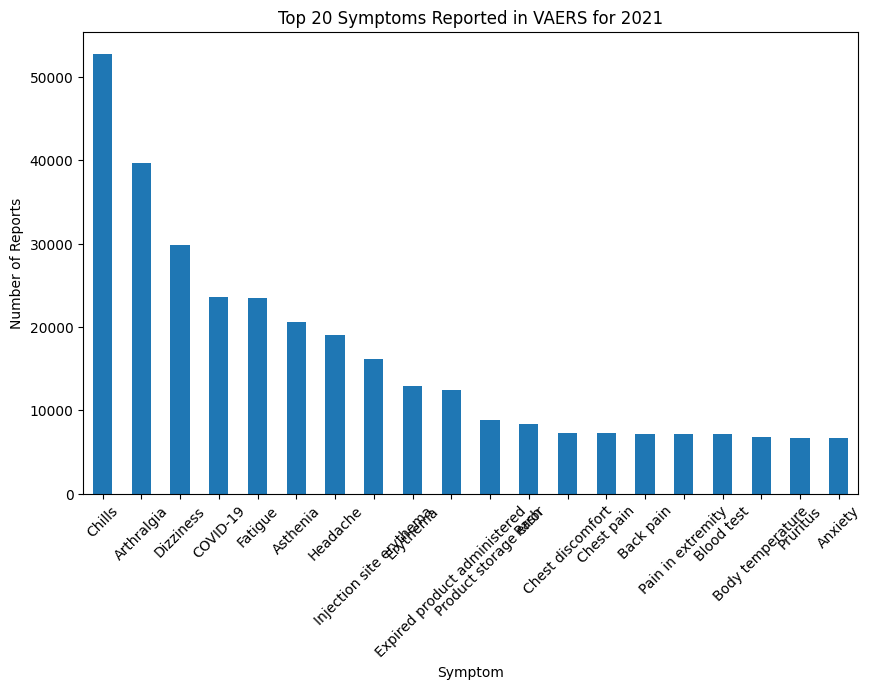

In [46]:
# prompt: plot symtoms1 top 20

import pandas as pd
import matplotlib.pyplot as plt

# Get the top 20 symptoms
top_20_symptoms = df_combine_2021['SYMPTOM1'].value_counts().head(20)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_20_symptoms.plot(kind='bar')

# Add title and labels
plt.title('Top 20 Symptoms Reported in VAERS for 2021')
plt.xlabel('Symptom')
plt.ylabel('Number of Reports')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [47]:
# prompt: how many people DIED by sex

died_by_sex = df_combine_2021.groupby('SEX')['DIED'].value_counts()
print(died_by_sex)


SEX  DIED
F    N       468487
     Y         4002
M    N       206991
     Y         5813
U    N        24951
     Y          421
Name: count, dtype: int64


In [48]:
# prompt: count SYMPTOM1

countSymtoms1=df_combine_2021['SYMPTOM1'].value_counts().head(20)
print(countSymtoms1)


SYMPTOM1
Chills                          52743
Arthralgia                      39643
Dizziness                       29830
COVID-19                        23633
Fatigue                         23451
Asthenia                        20590
Headache                        19063
Injection site erythema         16112
Erythema                        12927
Expired product administered    12490
Product storage error            8896
Rash                             8380
Chest discomfort                 7298
Chest pain                       7248
Back pain                        7135
Pain in extremity                7127
Blood test                       7115
Body temperature                 6754
Pruritus                         6733
Anxiety                          6727
Name: count, dtype: int64


In [49]:
# prompt: what us the most common symtom vaccine manu

most_common_symptom = df_combine_2021['SYMPTOM1'].mode()[0]
print(f"The most common symptom is: {most_common_symptom}")


The most common symptom is: Chills


In [50]:
# prompt: how many null values are the dataset df_vaers_vax_2021

df_combine_2021.isnull().sum()



VAERS_ID                0
RECVDATE                0
STATE              107462
AGE_YRS             67319
CAGE_YR            133567
CAGE_MO            709249
SEX                     0
RPT_DATE           709897
SYMPTOM_TEXT            0
DIED                    0
DATEDIED           701514
L_THREAT                0
ER_VISIT           710564
HOSPITAL                0
HOSPDAYS           680173
X_STAY                  0
DISABLE                 0
RECOVD                  0
VAX_DATE            46060
ONSET_DATE          54816
NUMDAYS             82144
LAB_DATA           489764
V_ADMINBY               0
V_FUNDBY           709838
OTHER_MEDS         354889
CUR_ILL            512812
HISTORY            350182
PRIOR_VAX          676120
SPLTTYPE           510083
FORM_VERS               0
TODAYS_DATE          5272
OFC_VISIT               0
ER_ED_VISIT             0
ALLERGIES          425925
VAX_TYPE                0
VAX_MANU                0
VAX_LOT            217922
VAX_DOSE_SERIES      2682
VAX_ROUTE   

Number of VAERS by state

In [64]:
# prompt: drop the following columns SYMPTOM_TEXT, CAGE_MO, RPT_DATE,RECVDATE,, DISABLE,CUR_ILL, PRIOR_VAX, BIRTH_DEFECT, SYMPTOM_TEXT, CAGE_MO, RPT_DATE,RECVDATE,, DISABLE,CUR_ILL, PRIOR_VAX, BIRTH_DEFECT

#df_combine_2021.drop(columns=['SYMPTOM_TEXT', 'CAGE_MO', 'RPT_DATE','RECVDATE','DISABLE','CUR_ILL', 'PRIOR_VAX', 'BIRTH_DEFECT','SYMPTOM2', 'SYMPTOM3','SYMPTOM4','SYMPTOM5','ALLERGIES'], axis=1, inplace=True, errors='ignore')


In [51]:
df_combine_2021['VAX_TYPE'].value_counts(normalize= True) * 100

VAX_TYPE
COVID19   100.000000
Name: proportion, dtype: float64

In [52]:
df_combine_2021['VAX_MANU'].value_counts(normalize= True) * 100

VAX_MANU
MODERNA                47.301190
PFIZER\BIONTECH        43.736078
JANSSEN                 8.747441
UNKNOWN MANUFACTURER    0.215291
Name: proportion, dtype: float64

In [53]:
df_combine_2021.columns

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES',
       'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES', 'VAX_ROUTE',
       'VAX_SITE', 'VAX_NAME', 'SYMPTOM1', 'SYMPTOMVERSION1',
       'SYMPTOMVERSION2', 'SYMPTOMVERSION3', 'SYMPTOMVERSION4',
       'SYMPTOMVERSION5', 'ADVERSE_EFFECT'],
      dtype='object')

In [54]:
pmc = ['CUR_ILL', 'HISTORY', 'ALLERGIES']

for i in pmc:
    print(df_combine_2021[[i]].value_counts(normalize= True).sort_values(ascending= False).head(50) * 100)
    print("\n\n")

CUR_ILL                          
none                                27.111037
No                                   5.952399
no                                   3.658777
NONE                                 3.287794
unknown                              2.959773
Unknown                              2.480630
None.                                2.199613
N/a                                  0.977999
UNKNOWN                              0.675249
None known                           0.635826
None reported                        0.595897
none known                           0.588316
NO                                   0.498350
none reported                        0.497844
Asthma                               0.422536
na                                   0.404846
Hypertension                         0.343690
Na                                   0.306288
Diabetes                             0.301234
Seasonal allergies                   0.228452
No.                                  0.210763


In [55]:
# prompt: give me numeric values vs categorical values

import pandas as pd



# Get numeric and categorical columns
numeric_cols = df_combine_2021.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_combine_2021.select_dtypes(include=['object']).columns

# Print the columns
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: Index(['VAERS_ID', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'HOSPDAYS', 'NUMDAYS',
       'FORM_VERS', 'SYMPTOMVERSION1', 'SYMPTOMVERSION2', 'SYMPTOMVERSION3',
       'SYMPTOMVERSION4', 'SYMPTOMVERSION5'],
      dtype='object')
Categorical columns: Index(['RECVDATE', 'STATE', 'SEX', 'RPT_DATE', 'SYMPTOM_TEXT', 'DIED',
       'DATEDIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL', 'X_STAY', 'DISABLE',
       'RECOVD', 'VAX_DATE', 'ONSET_DATE', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'TODAYS_DATE', 'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES', 'VAX_TYPE',
       'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES', 'VAX_ROUTE', 'VAX_SITE',
       'VAX_NAME', 'SYMPTOM1', 'ADVERSE_EFFECT'],
      dtype='object')


In [56]:
df_combine_2021['ER_VISIT'].value_counts()

ER_VISIT
Y    101
Name: count, dtype: int64

In [57]:
# Died - Replace 'nan' with 'N'
df_combine_2021['DIED'] = df_combine_2021['DIED'].replace({np.nan: 'N'})
# L_Threat - Replace 'nan' with 'N'
df_combine_2021['L_THREAT'] = df_combine_2021['L_THREAT'].replace({np.nan: 'N'})

# ER_ED_Visit - Replace 'nan' with 'N'
df_combine_2021['ER_VISIT'] = df_combine_2021['ER_VISIT'].replace({np.nan: 'N'})


# Hospital - Replace 'nan' with 'N'
df_combine_2021['HOSPITAL'] = df_combine_2021['HOSPITAL'].replace({np.nan: 'N'})

# Disable - Replace 'nan' with 'N'
#df_combine_2021['DISABLE'] = df_combine_2021['DISABLE'].replace({np.nan: 'N'})



In [59]:
df_combine_2021 = df_combine_2021.drop(columns= ['CUR_ILL', 'HISTORY', 'ALLERGIES', 'PRIOR_VAX'])
df_combine_2021.head()


,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,ER_VISIT,HOSPITAL,HOSPDAYS,X_STAY,DISABLE,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,SPLTTYPE,FORM_VERS,TODAYS_DATE,OFC_VISIT,ER_ED_VISIT,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,SYMPTOM1,SYMPTOMVERSION1,SYMPTOMVERSION2,SYMPTOMVERSION3,SYMPTOMVERSION4,SYMPTOMVERSION5,ADVERSE_EFFECT
0,916600,01/01/2021,TX,33.000000,33.000000,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,N,NaN,N,N,N,NaN,N,N,Y,12/28/2020,12/30/2020,2.000000,NaN,PVT,NaN,NaN,NaN,2,01/01/2021,Y,N,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA)),Dysphagia,23.100000,23.100000,NaN,NaN,NaN,Clinic_Visit
1,916601,01/01/2021,CA,73.000000,73.000000,NaN,F,NaN,Approximately 30 min post vaccination administ...,N,NaN,N,N,N,NaN,N,N,Y,12/31/2020,12/31/2020,0.000000,NaN,SEN,NaN,Patient residing at nursing facility. See pati...,NaN,2,01/01/2021,Y,N,COVID19,MODERNA,025L20A,1,IM,RA,COVID19 (COVID19 (MODERNA)),Anxiety,23.100000,23.100000,NaN,NaN,NaN,Clinic_Visit
2,916602,01/01/2021,WA,23.000000,23.000000,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",N,NaN,N,N,N,NaN,N,N,U,12/31/2020,12/31/2020,0.000000,NaN,SEN,NaN,NaN,NaN,2,01/01/2021,N,Y,COVID19,PFIZER\BIONTECH,EL1284,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),Chest discomfort,23.100000,23.100000,23.100000,23.100000,NaN,ER_Visit
3,916603,01/01/2021,WA,58.000000,58.000000,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",N,NaN,N,N,N,NaN,N,N,Y,12/23/2020,12/23/2020,0.000000,none,WRK,NaN,none,NaN,2,01/01/2021,N,N,COVID19,MODERNA,unknown,UNK,NaN,NaN,COVID19 (COVID19 (MODERNA)),Dizziness,23.100000,23.100000,23.100000,NaN,NaN,No_Adverse_Effect
4,916604,01/01/2021,TX,47.000000,47.000000,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",N,NaN,N,N,N,NaN,N,N,N,12/22/2020,12/29/2020,7.000000,NaN,PUB,NaN,Na,NaN,2,01/01/2021,N,N,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA)),Injection site erythema,23.100000,23.100000,23.100000,23.100000,NaN,No_Adverse_Effect


In [60]:
total =  df_combine_2021.isnull().sum()
percent = (df_combine_2021.isnull().sum() / len(df_combine_2021)) * 100

missing_df = pd.concat([total, percent], axis= 1, keys= ['Total', 'Percent'])
missing_df

,Total,Percent
VAERS_ID,0,0.000000
RECVDATE,0,0.000000
STATE,107462,15.121330
AGE_YRS,67319,9.472677
CAGE_YR,133567,18.794650
CAGE_MO,709249,99.800750
SEX,0,0.000000
RPT_DATE,709897,99.891932
SYMPTOM_TEXT,0,0.000000
DIED,0,0.000000


In [61]:
df_combine_2021.AGE_YRS.isnull().sum()

67319

In [62]:
# Age in years (AGE_YRS): The recorded vaccinated individual's age in years.
# Age in years (CAGE_YR): Age of patient in years calculated by (vax_date-birthdate)

# Since AGE_YRS alone is sufficient for analysis, we will be dropping the 'CAGE_YR' variable.
# But, before that, we impute the missing values in 'AGE_YRS' variable with it's corresponding values in 'CAGE_YR', if present.


# Finding missing values in 'AGE_YRS' for those which has corrsponding values in 'CAGE_YRS':

df_combine_2021[(df_combine_2021['AGE_YRS'].isnull()) & (~df_combine_2021['CAGE_YR'].isnull())][['AGE_YRS', 'CAGE_YR']].head()

,AGE_YRS,CAGE_YR
1012,NaN,56.000000
1084,NaN,46.000000
1651,NaN,54.000000
2056,NaN,35.000000
2179,NaN,34.000000


In [63]:
# Age in years (AGE_YRS): The recorded vaccinated individual's age in years.
# Age in years (CAGE_YR): Age of patient in years calculated by (vax_date-birthdate)

# Since AGE_YRS alone is sufficient for analysis, we will be dropping the 'CAGE_YR' variable.
# But, before that, we impute the missing values in 'AGE_YRS' variable with it's corresponding values in 'CAGE_YR', if present.


# Finding missing values in 'AGE_YRS' for those which has corrsponding values in 'CAGE_YRS':

df_combine_2021[(df_combine_2021['AGE_YRS'].isnull()) & (~df_combine_2021['CAGE_YR'].isnull())][['AGE_YRS', 'CAGE_YR']].head()

,AGE_YRS,CAGE_YR
1012,NaN,56.000000
1084,NaN,46.000000
1651,NaN,54.000000
2056,NaN,35.000000
2179,NaN,34.000000


In [65]:
df_combine_2021['AGE_YRS'] = df_combine_2021['AGE_YRS'].fillna(df_combine_2021['CAGE_YR'])
len(df_combine_2021[(df_combine_2021['AGE_YRS'].isnull()) & (~df_combine_2021['CAGE_YR'].isnull())][['AGE_YRS', 'CAGE_YR']])

0

In [ ]:
df_combine_2021.AGE_YRS.isnull().sum()
df_combine_2021 = df_combine_2021.drop(columns= ['CAGE_YR'])
df_combine_2021.head(3)

In [66]:
len(df_combine_2021[df_combine_2021['ONSET_DATE'] < df_combine_2021['VAX_DATE']][['VAX_DATE', 'ONSET_DATE']])

20661

In [67]:
df_combine_2021[df_combine_2021['ONSET_DATE'] < df_combine_2021['VAX_DATE']][['VAX_DATE', 'ONSET_DATE']].head()

,VAX_DATE,ONSET_DATE
37,12/31/2020,01/01/2021
59,12/31/2020,01/01/2021
64,12/31/2020,01/01/2021
68,12/31/2020,01/01/2021
74,12/31/2020,01/01/2021


In [68]:
df_combine_2021.loc[(df_combine_2021['ONSET_DATE'] < df_combine_2021['VAX_DATE']), 'ONSET_DATE'] = df_combine_2021['VAX_DATE']

In [69]:
len(df_combine_2021[df_combine_2021['ONSET_DATE'] < df_combine_2021['VAX_DATE']][['VAX_DATE', 'ONSET_DATE']])

0

Missing Values in 'NUMDAYS' based on 'VAX_DATE' & 'ONSET_DATE'

In [70]:
df_combine_2021['NUMDAYS'].isnull().sum()

82144

In [72]:
len(df_combine_2021[(df_combine_2021['NUMDAYS'].isnull()) & (~df_combine_2021['VAX_DATE'].isnull()) & (~df_combine_2021['ONSET_DATE'].isnull())][['VAX_DATE', 'ONSET_DATE', 'NUMDAYS']])

12491

In [73]:
df_combine_2021[(df_combine_2021['NUMDAYS'].isnull()) & (~df_combine_2021['VAX_DATE'].isnull()) & (~df_combine_2021['ONSET_DATE'].isnull())][['VAX_DATE', 'ONSET_DATE', 'NUMDAYS']].head()

,VAX_DATE,ONSET_DATE,NUMDAYS
343,12/28/2020,12/28/2020,NaN
460,12/29/2020,12/29/2020,NaN
2100,12/22/2020,12/22/2020,NaN
2108,12/20/2020,12/20/2020,NaN
2115,12/22/2020,12/22/2020,NaN


In [76]:
# Convert the date columns to datetime objects
df_combine_2021['ONSET_DATE'] = pd.to_datetime(df_combine_2021['ONSET_DATE'])
df_combine_2021['VAX_DATE'] = pd.to_datetime(df_combine_2021['VAX_DATE'])

# Now calculate the difference and store the result in days
df_combine_2021['NUMDAYS'] = (df_combine_2021['ONSET_DATE'] - df_combine_2021['VAX_DATE']) / np.timedelta64(1, 'D')
#df_combine_2021['NUMDAYS'] = (df_combine_2021['ONSET_DATE'] - df_combine_2021['VAX_DATE']) / np.timedelta64(1, 'D')

In [77]:
len(df_combine_2021[(df_combine_2021['NUMDAYS'].isnull()) & (~df_combine_2021['VAX_DATE'].isnull()) & (~df_combine_2021['ONSET_DATE'].isnull())][['VAX_DATE', 'ONSET_DATE', 'NUMDAYS']])

0

In [78]:
df_combine_2021['NUMDAYS'].isnull().sum()

69653

Pre-Processing of variable - 'NUMDAYS'

In [79]:
# Renaming a column - 'NUMDAYS':

df_combine_2021.rename(columns = {'NUMDAYS': 'NUMDAYS BETWEEN VAX_DATE & ONSET_DATE'}, inplace = True)

In [80]:
len(df_combine_2021[df_combine_2021['NUMDAYS BETWEEN VAX_DATE & ONSET_DATE']>365])

632

In [81]:
df_combine_2021[df_combine_2021['NUMDAYS BETWEEN VAX_DATE & ONSET_DATE']>365][['VAX_DATE', 'ONSET_DATE', 'NUMDAYS BETWEEN VAX_DATE & ONSET_DATE']].head()

,VAX_DATE,ONSET_DATE,NUMDAYS BETWEEN VAX_DATE & ONSET_DATE
302,1992-07-10,2020-12-29,10399.000000
379,1959-09-13,2020-12-27,22386.000000
413,2019-12-23,2020-12-28,371.000000
1112,2020-01-02,2021-01-02,366.000000
1393,2020-01-02,2021-01-02,366.000000


In [82]:
df_combine_2021 = df_combine_2021[~(df_combine_2021['NUMDAYS BETWEEN VAX_DATE & ONSET_DATE']>365)]
df_combine_2021.shape

(710033, 44)

In [1]:
# prompt: Can factors like age, gender, vaccine brand, and medical conditions help predict how strongly someone might react to the vaccine?, import  libraries ypu will need

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the data
df = df_combine_2021.copy()

# Preprocess the data
df.dropna(inplace=True)

# Create dummy variables for categorical features
df = pd.get_dummies(df, drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_combine_2021.drop('DIED', axis=1), df_combine_2021['DIED'], test_size=0.25, random_state=0)

# Train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Get the coefficients of the model
coefficients = model.coef_

# Create a dataframe of the coefficients
coef_df = pd.DataFrame(coefficients, columns=X_train.columns)

# Sort the coefficients by absolute value
coef_df = coef_df.abs().sort_values(by=0, ascending=False)

# Print the top 10 coefficients
print(coef_df.head(10))



NameError: name 'df_combine_2021' is not defined

In [69]:
# prompt: Can factors like age, gender, vaccine brand, and medical conditions help predict how strongly someone might react to the vaccine?

import pandas as pd

# Select the relevant columns
df = df[['AGE_YRS', 'SEX', 'VAX_MANU', 'DIED']]

# Group the data by age, sex, vaccine brand, and death
grouped_data = df.groupby(['AGE_YRS', 'SEX', 'VAX_MANU', 'DIED']).size().unstack()

# Calculate the percentage of people who died for each group
grouped_data = grouped_data.apply(lambda x: x / x.sum() * 100, axis=1)

# Print the results
print(grouped_data)

# You can use this data to analyze the relationship between age, sex, vaccine brand, and the likelihood of death after vaccination. For example, you could use this data to identify groups of people who are at higher risk of experiencing severe side effects from the vaccine.


DIED                             N   Y
AGE_YRS SEX VAX_MANU                  
0.08    F   JANSSEN          100.0 NaN
            MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN
        M   MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN
...                            ...  ..
115.00  F   PFIZER\BIONTECH  100.0 NaN
119.00  F   MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN
        U   MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN

[1157 rows x 2 columns]


In [82]:
# prompt: Can factors like age, gender, vaccine brand, and medical conditions help predict how strongly someone might react to the vaccine?

import pandas as pd

# Read the data into a DataFrame

df=df_combine_2021.copy()

# Select the relevant columns
df = df[['AGE_YRS', 'SEX', 'VAX_MANU', 'DIED']]

# Group the data by age, sex, vaccine brand, and death
grouped_data = df.groupby(['AGE_YRS', 'SEX', 'VAX_MANU', 'DIED']).size().unstack()

# Calculate the percentage of people who died for each group
grouped_data = grouped_data.apply(lambda x: x / x.sum() * 100, axis=1)

# Print the results
print(grouped_data)


DIED                             N   Y
AGE_YRS SEX VAX_MANU                  
0.08    F   JANSSEN          100.0 NaN
            MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN
        M   MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN
...                            ...  ..
115.00  F   PFIZER\BIONTECH  100.0 NaN
119.00  F   MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN
        U   MODERNA          100.0 NaN
            PFIZER\BIONTECH  100.0 NaN

[1157 rows x 2 columns]


In [68]:
df_combine_2021.columns

Index(['AGE_YRS', 'SEX', 'DIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL', 'DISABLE',
       'BIRTH_DEFECT', 'VAX_TYPE', 'VAX_MANU', 'VAX_NAME', 'SYMPTOM1',
       'ALL_SYMPTOMS'],
      dtype='object')

In [71]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [4]:
cat = []
num = []

for i in df_combine_2021.columns:
    if df_combine_2021[i].dtype==object:
        cat.append(i)
    else:
        num.append(i)

print("The number of numerical features are:",len(num))
print()
print("The numerical features are:\n\n",num)
print("\n\n")
print("The number of categorical features are:", len(cat))
print()
print("The categorical features are:\n\n",cat)

NameError: name 'df_combine_2021' is not defined

In [3]:
df_v1=df_combine_2021.copy()
df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'N') & (df_v1['ER_ED_VISIT'] == 'N') & (df_v1['HOSPITAL'] == 'N') & (df_v1['X_STAY'] == 'N') & (df_v1['OFC_VISIT'] == 'N') & (df_v1['DISABLE'] == 'N') & (df_v1['BIRTH_DEFECT'] == 'Y')), 'ADVERSE_EFFECT'] = 'Birth_Defect'

df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'N') & (df_v1['ER_ED_VISIT'] == 'N') & (df_v1['HOSPITAL'] == 'N') & (df_v1['X_STAY'] == 'N') & (df_v1['OFC_VISIT'] == 'N') & (df_v1['DISABLE'] == 'Y')), 'ADVERSE_EFFECT'] = 'Disabled'

df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'N') & (df_v1['ER_ED_VISIT'] == 'N') & (df_v1['HOSPITAL'] == 'N') & (df_v1['X_STAY'] == 'N') & (df_v1['OFC_VISIT'] == 'Y')), 'ADVERSE_EFFECT'] = 'Clinic_Visit'

df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'N') & (df_v1['ER_ED_VISIT'] == 'N') & (df_v1['X_STAY'] == 'N')  & (df_v1['HOSPITAL'] == 'Y')), 'ADVERSE_EFFECT'] = 'Hospitalized'

df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'N') & (df_v1['ER_ED_VISIT'] == 'N') & (df_v1['X_STAY'] == 'Y')), 'ADVERSE_EFFECT'] = 'Prolonged_Hospitalization'

df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'N') & (df_v1['ER_ED_VISIT'] == 'Y')), 'ADVERSE_EFFECT'] = 'ER_Visit'

df_v1.loc[((df_v1['DIED'] == 'N') & (df_v1['L_THREAT'] == 'Y')), 'ADVERSE_EFFECT'] = 'Life_Threat'

df_v1.loc[((df_v1['DIED'] == 'Y')), 'ADVERSE_EFFECT'] = 'Died'

NameError: name 'df_combine_2021' is not defined

In [1]:
df_combine_2021.columns
df_combine_2021.head()

NameError: name 'df_combine_2021' is not defined